In [3]:

from scipy.stats import norm
from src.halo_mass_history import HaloMassHistory
from src.halo_mass_function import HaloMassFunction

from joblib import Parallel, delayed
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import RegularGridInterpolator

In [ ]:
def precompute_dndM_interpolator(M1):
    """
    Precompute the halo number density dndM for a range of redshifts
    and store the result in an interpolator using parallel computation.
    """
    # Define a range of redshifts to compute dndM
    n_z = 300  # Number of redshift values to compute
    z_prime_grid = np.logspace(1.6, -3, n_z)  # Redshift range # upto z ~ 40
    
    N1, N2 = M1.shape  # Get dimensions of the meshgrid

    # Parallel computation for dndM over the redshift grid
    dndM_values_list = Parallel(n_jobs=-1, verbose=5)(
        delayed(compute_dndM)(z_prime, M1) for z_prime in z_prime_grid
    )

    # Convert list of results to a NumPy array
    dndM_values = np.array(dndM_values_list)  # Shape: (n_z, N1, N2)

    # Reverse both for interpolation (matching the order of the original code)
    z_prime_grid_sorted = z_prime_grid[::-1]
    dndM_values_sorted = dndM_values[::-1, :, :]

    # Reshape for interpolation (flatten the mass grid dimensions)
    dndM_values_reshaped = dndM_values_sorted.reshape(n_z, -1)

    # Build the interpolator for halo number density
    dndM_interpolator = RegularGridInterpolator(
        (z_prime_grid_sorted,), dndM_values_reshaped, bounds_error=False, fill_value=0
    )

    return dndM_interpolator

def compute_dndM(z_prime, M):
    """
    Compute the number density of halos for a single redshift z_prime.
    """
    hmf_z = HaloMassFunction(z_prime)   
    dndM_grid = hmf_z.dndm(M/h)  
    return dndM_grid

def p_occ(M1, z_prime, n_BH, mu, sigma, logM_min, dndM_interpolator, zmax = 10):
    """
    Occupation fraction at z_prime for BH masses m using threshold CDF approach.
    """
    hmf_0 = HaloMassFunction(0)

    # Evolve the z=zmax seed‐halo log-normal mean & lower bound to z_prime
    M0_mu  = 10**mu
    M0_min = 10**logM_min

    mu_z   = HaloMassHistory(M0_mu,  zmax, hmf_0).mass_at_z_from_zi(z_prime)
    Mmin_z = HaloMassHistory(M0_min, zmax, hmf_0).mass_at_z_from_zi(z_prime)

    # Fetch precomputed halo mass function : dndM(M1, z_prime)
    dndM_val_flat = dndM_interpolator(np.array([z_prime]))[0]
    phi = dndM_val_flat.reshape(M1.shape)

    # Compute the truncated-threshold CDF in log10 M
    logmu_z   = np.log10(mu_z)
    logmin_z  = np.log10(Mmin_z)
    delta     = (np.log10(M1) - logmu_z) / sigma
    delta_min = (logmin_z - logmu_z) / sigma

    cdf       = norm.cdf(delta)                   # \Phi((logM - logmu)/σ)
    cdf_min   = norm.cdf(delta_min)               # \Phi((logMmin - logmu)/σ)
    p_cdf     = (cdf - cdf_min) / (1.0 - cdf_min)  # truncated CDF
    p_cdf[M1 < Mmin_z] = 0.0                       # zero below absolute min

    # Solve for p_max by matching n_BH = ∫ p_cdf(M) \Phi(M) dM
    #    approximate integral with trapezoidal rule over unique M1
    mask = M1[0]
    M_list = M1[0]
    phi_list = phi[0]
    p_list   = p_cdf[0]
    integral   = np.trapezoid(p_list * phi_list, x = M_list)
    p_max      = n_BH / integral

    # Final occupation probability
    p_occ_val = np.clip(p_max * p_cdf, 0.0, 1.0)
    return p_occ_val

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 285 out of 300 | elapsed:    4.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    4.7s finished


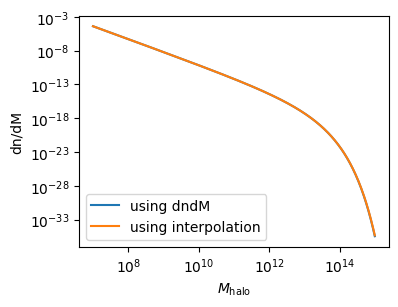

In [35]:
z = 2.5
h = 0.674
hmf_z = HaloMassFunction(z)

# Define halo masses m1 and m2 
mass1 = np.logspace(7, 15, 500)  # Msun
mass2 = np.logspace(7, 15, 500)  # Msun
# Create a meshgrid for m1 and m2
m1_halo_grid, m2_halo_grid = np.meshgrid(mass1, mass2)

plt.figure(figsize=(4, 3), dpi = 100)

dn_dM_1 = hmf_z.dndm(m1_halo_grid / h)
plt.loglog(m1_halo_grid[0], dn_dM_1[0], label = 'using dndM')

dndM_interpolator = precompute_dndM_interpolator(m1_halo_grid)
dndM_val_flat = dndM_interpolator(np.array([z]))[0]
dn_dM_3 = dndM_val_flat.reshape(m1_halo_grid.shape)

plt.loglog(m1_halo_grid[0], dn_dM_3[0], label = 'using interpolation')

plt.xlabel('$M_{\\rm halo}$')
plt.ylabel('dn/dM')
# plt.ylim(1e-14, )
plt.legend()

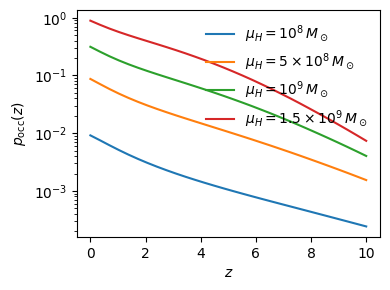

In [37]:
z_values = np.linspace(0.001, 10, 30)

# Choose a fixed index in the mass grid (for example, the one at the middle)
fixed_mass_index = 400  # change this index as desired

# print(f'{m1_halo_grid[0, fixed_mass_index]:.2e}')
plt.figure(figsize=(4, 3), dpi = 100)

M_z_maximum = [8, 8.7, 9, 9.178] #9.244]
for M_max in M_z_maximum:
    p_occ_vs_z = []
    for z in z_values:
        n_BH = 5e-3
        mu = M_max
        sigma = 0.5
        logM_min = 7.
        occ = p_occ(m1_halo_grid, z, n_BH, mu, sigma, logM_min, dndM_interpolator, zmax = 10)
        # occ = p_occ(m1_halo_grid, z, dndM_interpolator, M_max) #n_halo_interpolator

        p_occ_fixed = occ[0, fixed_mass_index]
        p_occ_vs_z.append(p_occ_fixed)
    
    plt.plot(z_values, p_occ_vs_z, linestyle='-')
    # print(p_occ_vs_z[0])

plt.yscale('log')
plt.xlabel("$z$", fontsize = 10)
plt.ylabel("$p_{\\rm occ}(z)$",  fontsize = 10)
plt.legend([r'$\mu_H = 10^8 \, M_\odot$', r'$\mu_H = 5 \times 10^8 \, M_\odot$', r'$\mu_H = 10^9 \, M_\odot$', r'$\mu_H = 1.5 \times 10^9 \, M_\odot$', ], loc = 'upper right',  fontsize = 10, frameon = False)
# plt.grid(True, which='major', linestyle='-.', alpha=0.4)
plt.tight_layout()
# plt.ylim(1e-5,)
plt.savefig('Figures/p_occ.pdf', bbox_inches='tight')